In [12]:
#************************************************************************************
# Rezwan Matin
# EE5321 – Project
# Filename: ML_RAVDESS_2.py
# Due: 01/29/20
#
# Objective:
# 13 MFCCs (mean) and 13 MFCCs (standard deviation), ZCR with background sound (city center noise).
#
#*************************************************************************************

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as rosa
import glob
import os
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# Save directory path in 'path'
path = r'C:\Books\Texas State Books\Fall 2019\Thesis A\Corpus\Simulated\RAVDESS\All_Background Noise'

# Declare a dummy Numpy array (row vector)
result_array = np.empty([1,28])

# Create a list of audio file names 'file_list'
file_list = os.listdir(path)

i=0

for filename in file_list:
    
    # Read WAV file. 'rosa.core.load' returns sampling frequency in 'fs' and audio signal in 'sig'
    sig, fs = rosa.core.load(path + '\\' + file_list[i], sr=None)
    
    # 'rosa.feature.mfcc' extracts n_mfccs from signal and stores it into 'mfcc_feat'
    mfcc_feat = rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=13)
    
    # Calculate the average mfcc (utterance-level features) using 'rosa.feat.mfcc()' and 'np.mean' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    avg_mfcc_feat = np.mean(rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=13).T,axis=0)
    
    # Calculate the standard deviation of mfcc (utterance-level features) using 'rosa.feat.mfcc()' and 'np.std' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    std_mfcc_feat = np.std(rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=13).T,axis=0)
    
    # Calculate the average zero crossing rate (utterance-level feature) using 'rosa.feat.zero_crossing_rate()' and 'np.mean' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    zcross_feat = rosa.feature.zero_crossing_rate(sig)
    avg_zcross_feat = np.mean(rosa.feature.zero_crossing_rate(y=sig).T,axis=0)
    
    # Append the three 1D arrays into a single 1D array called 'feat'.
    feat0 = np.append(avg_mfcc_feat, std_mfcc_feat, axis=0)
    
    feat1 = np.append(feat0, avg_zcross_feat, axis=0)
    
    # Save emotion label from file name. 'path' contains directory's address, 'file_list' contains file name, and '\\' joins the two to form file's address
    label = os.path.splitext(os.path.basename(path + '\\' + file_list[i]))[0].split('-')[2]
    
    # Create a new Numpy array 'sample' to store features along with label
    sample = np.insert(feat1, obj=27, values=label)
    
    result_array = np.append(result_array, sample)
    
    i+=1

# Print out the 1D Numpy array
result_array

array([8.60637751e-316, 9.23902758e-322, 0.00000000e+000, ...,
       7.41179835e+000, 5.44583944e-002, 8.00000000e+000])

In [3]:
result_array.shape

(40348,)

In [4]:
# Convert 1D Numpy array to 2D array
result_array = np.reshape(result_array, (i+1,-1))

# Delete first dummy row from 2D array
result_array = np.delete(result_array, 0, 0)

# Print final 2D Numpy array 
result_array.shape

(1440, 28)

In [5]:
df = pd.DataFrame(data=result_array)
# Label only the last (target) column
df = df.rename({27: "Emotion"}, axis='columns')
# Delete unnecessary emotion data (calm)
df.drop(df[df['Emotion'] == 2.0].index, inplace = True)
df['Emotion'].replace({1.0: "Neutral", 3.0: "Happy", 4.0: "Sad", 5.0: "Angry", 6.0: "Fearful", 7.0: "Disgust", 8.0: "Surprised"}, inplace=True)
# Reset row (sample) indexing
df = df.reset_index(drop=True)
df.head(12)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,Emotion
0,-370.811277,200.945609,-25.601894,12.781816,-23.361012,12.480950,-7.339299,-13.182599,-9.380556,-4.284814,...,7.370330,6.816342,7.540840,7.194957,5.718780,6.775456,6.336632,6.502535,0.034162,Neutral
1,-366.069746,199.358091,-26.372811,12.007660,-23.430119,12.148651,-8.856314,-11.990725,-10.876269,-3.940869,...,7.213498,7.230598,9.840123,7.512177,6.090867,7.543311,6.376425,5.980978,0.035070,Neutral
2,-367.049981,200.153470,-26.128286,13.793804,-24.219043,12.738294,-8.241901,-13.965553,-9.749571,-4.039100,...,8.349078,7.150616,7.280647,6.468727,5.918388,6.280770,6.708307,6.305197,0.035434,Neutral
3,-369.243934,200.255975,-26.802738,13.414320,-23.770417,11.575530,-7.762641,-12.993787,-9.703835,-4.745808,...,7.398517,7.340771,8.428535,6.616107,6.049964,6.218078,6.335673,5.985354,0.034558,Neutral
4,-373.014555,202.287711,-25.378644,12.692684,-24.181430,12.424396,-6.634761,-14.236648,-8.780441,-4.394664,...,6.862773,6.140952,6.944213,6.423495,5.627796,5.724563,6.201933,5.928738,0.033748,Neutral
5,-372.649868,201.983061,-26.475035,12.527525,-24.256549,12.185351,-6.724715,-14.481719,-8.248213,-5.088603,...,7.305335,6.386489,6.761777,6.094591,5.405375,5.567920,6.456776,5.844796,0.034124,Neutral
6,-367.799723,198.911957,-24.865549,12.917156,-24.776742,13.426679,-8.249437,-13.896153,-9.868086,-3.332101,...,8.061086,6.525293,7.656357,6.938006,6.064813,6.276695,6.052823,6.222165,0.035946,Neutral
7,-369.898067,200.121781,-25.290541,13.452877,-24.315592,13.196527,-8.291886,-12.239270,-9.568036,-4.879833,...,7.512361,7.309666,8.048516,6.723401,5.545237,6.033411,6.303253,5.752904,0.035156,Neutral
8,-373.579880,203.821938,-24.900205,14.049376,-22.587316,13.227645,-4.889046,-13.473050,-7.067546,-3.792451,...,6.714845,6.540329,6.780845,6.297215,5.716515,5.695753,6.474567,6.310857,0.032786,Neutral
9,-353.494818,190.893053,-19.030947,11.677804,-23.301991,14.005309,-10.621754,-10.408835,-12.782006,-3.391942,...,8.443746,8.344449,9.717237,8.486049,6.948791,8.313236,6.963491,6.943699,0.035009,Neutral


In [6]:
df['Emotion'].value_counts()

Disgust      192
Surprised    192
Angry        192
Fearful      192
Sad          192
Happy        192
Neutral       96
Name: Emotion, dtype: int64

In [7]:
# Balance the dataset for equal number of samples for each class.
# Separate majority and minority classes
df_minority = df[df.Emotion=="Neutral"]
df_majority3 = df[df.Emotion=="Happy"]
df_majority4 = df[df.Emotion=="Sad"]
df_majority5 = df[df.Emotion=="Angry"]
df_majority6 = df[df.Emotion=="Fearful"]
df_majority7 = df[df.Emotion=="Disgust"]
df_majority8 = df[df.Emotion=="Surprised"]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=192,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority3, df_majority4, df_majority5, df_majority6, df_majority7, df_majority8])
 
# Display new class counts
df_upsampled.Emotion.value_counts()

# Reset row (sample) indexing
df_upsampled = df_upsampled.reset_index(drop=True)

df_upsampled['Emotion'].value_counts()

Neutral      192
Disgust      192
Surprised    192
Angry        192
Fearful      192
Sad          192
Happy        192
Name: Emotion, dtype: int64

In [8]:
# Extract target feature 'Emotion' in a vector y. Indexing from 0
y = df_upsampled.iloc[0:1344, 27].values
# Extract features 'buying' and 'safety' in a vector X. Indexing from 0
X = df_upsampled.iloc[0:1344, list(range(27))].values
print(y)

['Neutral' 'Neutral' 'Neutral' ... 'Surprised' 'Surprised' 'Surprised']


In [9]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# Create an object 'sc'
sc = StandardScaler()

# Scale training data
sc.fit(X_train)
X_train_std = sc.transform(X_train)

In [10]:
# Create SVM model with hyperparameters
#svm = SVC(kernel='sigmoid', C=10.0, random_state=1)

# Best settings from GridSearchCV
svm = SVC(kernel='rbf', C=4.88, gamma=0.0991, random_state=1)

# This is training the model
svm.fit(X_train_std, y_train)

SVC(C=4.88, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0991, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
# Scale test data
sc.fit(X_test)
X_test_std = sc.transform(X_test)

# Test the model data
y_pred = svm.predict(X_test_std)

In [12]:
# Print out the performance metrics
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Training Accuracy: %.2f' % svm.score(X_train_std, y_train))
#print('Test Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Test Accuracy: %.2f' % svm.score(X_test_std, y_test))

# Print out the performance metrics in a text file.
#text_file = open("Emotion Classifier Performance Metrics.txt", "w")
#text_file.write('Misclassified samples: %d' % (y_test != y_pred).sum())
#text_file.write('Training Accuracy: %.2f' % svm.score(X_train_std, y_train))
#text_file.write('Test Accuracy: %.2f' % svm.score(X_test_std, y_test))
#text_file.close()

Misclassified samples: 135
Training Accuracy: 0.86
Test Accuracy: 0.60


In [9]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# This is the setup, nothing gets executed yet…
#pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=2), SVC(random_state=1))

# Create an object 'sc'
sc = StandardScaler()

# Scale training data
sc.fit(X_train)
X_train_std = sc.transform(X_train)

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

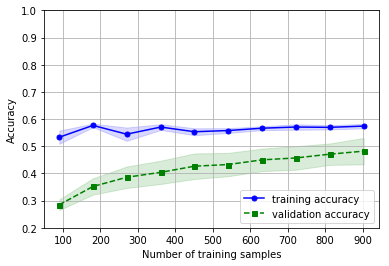

In [10]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svc, X=X_train_std, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = plt.figure()
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.2, 1.0])
plt.show()

# Save plot as PNG file
fig.savefig('Learning curve noise.png')

In [9]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# This is the setup, nothing gets executed yet…
#pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=2), SVC(random_state=1))

# Create an object 'sc'
sc = StandardScaler()

# Scale training data
sc.fit(X_train)
X_train_std = sc.transform(X_train)

# Scale test data
sc.fit(X_test)
X_test_std = sc.transform(X_test)

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

In [10]:
pipe_svc.fit(X_train_std, y_train)
y_pred = pipe_svc.predict(X_test_std)
#class_names = df_upsampled['Emotion'].unique()
class_names = np.unique(y_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=class_names)
print(confmat)
confmat.shape
pd.DataFrame(confmat, index=class_names, columns=class_names)

[[28  4  2  5  1  1  7]
 [ 6 19  2  1  7  9  4]
 [ 3  1 15  5 13  1 10]
 [ 1  4  2 20 10  3  8]
 [ 0  6  0  1 38  1  2]
 [ 5  4  1  5 21  9  3]
 [ 2  7  3  4  6  2 24]]


,Angry,Disgust,Fearful,Happy,Neutral,Sad,Surprised
Angry,28,4,2,5,1,1,7
Disgust,6,19,2,1,7,9,4
Fearful,3,1,15,5,13,1,10
Happy,1,4,2,20,10,3,8
Neutral,0,6,0,1,38,1,2
Sad,5,4,1,5,21,9,3
Surprised,2,7,3,4,6,2,24


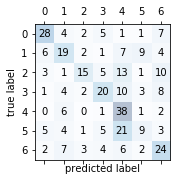

In [30]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()
fig.savefig('Confusion matrix noise.png')

Confusion matrix, without normalization
[[28  4  2  5  1  1  7]
 [ 6 19  2  1  7  9  4]
 [ 3  1 15  5 13  1 10]
 [ 1  4  2 20 10  3  8]
 [ 0  6  0  1 38  1  2]
 [ 5  4  1  5 21  9  3]
 [ 2  7  3  4  6  2 24]]


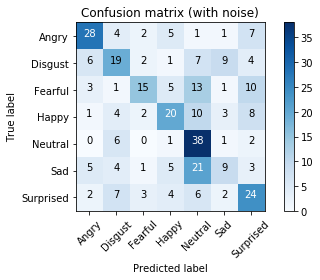

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(confmat, class_names, title='Confusion matrix (with noise)')
plt.show()